In [1]:
#intsall trimesh
!pip install trimesh

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 688.5/688.5 kB 13.6 MB/s eta 0:00:00


In [2]:
#Import necessary libraries
from tensorflow import keras
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import trimesh
import os
import datetime
import glob
from urllib.request import urlopen
import zipfile

In [3]:
#setting seed to one to generate the same sequence everytime
tf.random.set_seed(1)

In [4]:
#Data Url
url = "http://3dvision.princeton.edu/projects/2014/3DShapeNets/ModelNet10.zip"

#read the data and download it on local
response = urlopen(url)
with open("modelnet.zip", 'wb') as zip_file:
    zip_file.write(response.read())

#extract the zipfile
with zipfile.ZipFile("modelnet.zip", 'r') as zip_ref:
    zip_ref.extractall(".")

#set the directory
DATA_DIR = os.path.join(".", "ModelNet10")

In [5]:
# sample point from data
mesh = trimesh.load(os.path.join(DATA_DIR, "monitor/train/monitor_0001.off"))
mesh.show()
#Please rotate the mesh to see better

In [6]:
def parse_dataset(num_points=2048):
    train_points = []
    train_labels = []
    test_points = []
    test_labels = []
    class_map = {}
    folders = glob.glob(os.path.join(DATA_DIR, "[!README]*"))
    for class_id, folder in enumerate(folders):
        print("Processing class: {}".format(os.path.basename(folder)))
        class_map[class_id] = os.path.basename(folder)
        train_files = glob.glob(os.path.join(folder, "train/*"))
        test_files = glob.glob(os.path.join(folder, "test/*"))
        for files, points, labels in [(train_files, train_points, train_labels), (test_files, test_points, test_labels)]:
            for f in files:
                points.append(trimesh.load(f).sample(num_points))
                labels.append(class_id)
    return (
        np.array(train_points),
        np.array(test_points),
        np.array(train_labels),
        np.array(test_labels),
        class_map,
    )

In [7]:
NUM_POINTS = 2048
NUM_CLASSES = 10
BATCH_SIZE = 32

train_points, test_points, train_labels, test_labels, CLASS_MAP = parse_dataset(
    NUM_POINTS
)

Processing class: desk
Processing class: night_stand
Processing class: bathtub
Processing class: monitor
Processing class: toilet
Processing class: table
Processing class: sofa
Processing class: bed
Processing class: chair
Processing class: dresser


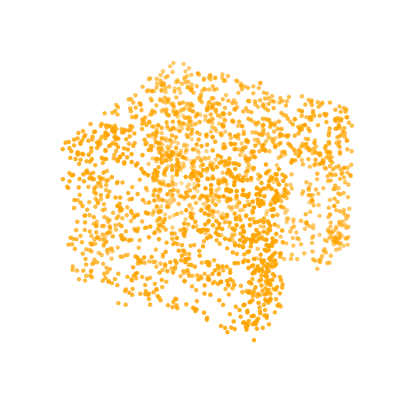

In [8]:
from mpl_toolkits.mplot3d import Axes3D

# Assuming `points` is a NumPy array containing the 3D coordinates
mesh = trimesh.load(os.path.join(DATA_DIR, "desk/train/desk_0001.off"))
points = mesh.sample(2048)

# Create a 3D scatter plot
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(points[:, 0], points[:, 1], points[:, 2], s=5, c='#FFA500', marker='o')

# Customize plot appearance
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_zlabel('Z-axis')
ax.set_axis_off()

# Show the plot
plt.show()

In [9]:
def augment(points, label):
    # Jitter points
    points += tf.random.uniform(points.shape, -0.005, 0.005, dtype=tf.float64)
    # Shuffle points
    points = tf.random.shuffle(points)
    return points, label

def create_dataset(points, labels, batch_size, augment_func=None, shuffle_buffer_size=None):
    dataset = tf.data.Dataset.from_tensor_slices((points, labels))

    if augment_func:
        dataset = dataset.map(augment_func)

    if shuffle_buffer_size:
        dataset = dataset.shuffle(shuffle_buffer_size)

    return dataset.batch(batch_size)

# Example usage
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = len(train_points)  # Set the buffer size as the length of the dataset for complete shuffling

train_dataset = create_dataset(train_points, train_labels, BATCH_SIZE, augment, SHUFFLE_BUFFER_SIZE)
test_dataset = create_dataset(test_points, test_labels, BATCH_SIZE, shuffle_buffer_size=len(test_points))

In [10]:
def conv_bn(x, filters, kernel_size=1, activation="relu"):
    x = keras.layers.Conv1D(filters, kernel_size=kernel_size, padding="valid")(x)
    x = keras.layers.BatchNormalization(momentum=0.0)(x)
    return keras.layers.Activation(activation)(x)

def dense_bn(x, units, activation="relu"):
    x = keras.layers.Dense(units)(x)
    x = keras.layers.BatchNormalization(momentum=0.0)(x)
    return keras.layers.Activation(activation)(x)

In [11]:
class OrthogonalRegularizer(keras.regularizers.Regularizer):
    def __init__(self, num_features, l2reg=0.001):
        self.num_features = num_features
        self.l2reg = l2reg
        self.eye = tf.eye(num_features)

    def __call__(self, x):
        x = tf.reshape(x, (-1, self.num_features, self.num_features))
        xxt = tf.tensordot(x, x, axes=(2, 2))
        xxt = tf.reshape(xxt, (-1, self.num_features, self.num_features))
        return tf.reduce_sum(self.l2reg * tf.square(xxt - self.eye))

In [12]:
def t_net_block(inputs, num_features):
    x = conv_bn(inputs, 32)
    x = conv_bn(x, 64)
    x = conv_bn(x, 512)
    x = keras.layers.GlobalMaxPooling1D()(x)
    x = dense_bn(x, 256)
    x = dense_bn(x, 128)
    return x

def t_net(inputs, num_features):
    bias = keras.initializers.Constant(np.eye(num_features).flatten())
    reg = OrthogonalRegularizer(num_features)

    x = t_net_block(inputs, num_features)
    x = keras.layers.Dense(
        num_features * num_features,
        kernel_initializer="zeros",
        bias_initializer=bias,
        activity_regularizer=reg,
    )(x)
    feat_T = keras.layers.Reshape((num_features, num_features))(x)
    return keras.layers.Dot(axes=(2, 1))([inputs, feat_T])

In [13]:
def create_pointnet_model(num_points, num_classes):
    inputs = keras.Input(shape=(num_points, 3))
    x = t_net(inputs, 3)
    x = conv_bn(x, 32)
    x = conv_bn(x, 32)
    x = t_net(x, 32)
    x = conv_bn(x, 32)
    x = conv_bn(x, 64)
    x = conv_bn(x, 512)
    x = keras.layers.GlobalMaxPooling1D()(x)
    x = dense_bn(x, 256)
    x = keras.layers.Dropout(0.3)(x)
    x = dense_bn(x, 128)
    x = keras.layers.Dropout(0.3)(x)
    outputs = keras.layers.Dense(num_classes, activation="softmax")(x)

    model = keras.Model(inputs=inputs, outputs=outputs, name="pointnet")
    return model

# Main model
NUM_POINTS = 2048
NUM_CLASSES = 10

pointnet_model = create_pointnet_model(NUM_POINTS, NUM_CLASSES)
pointnet_model.summary()

Model: "pointnet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 2048, 3)]            0         []                            
                                                                                                  
 conv1d (Conv1D)             (None, 2048, 32)             128       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 2048, 32)             128       ['conv1d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 2048, 32)             0         ['batch_normalization[0

In [33]:
with open('modelsummary.txt', 'w') as f:
    pointnet_model.summary(print_fn=lambda x: f.write(x + '\n'))

In [28]:
def sparse_categorical_crossentropy_loss(y_true, y_pred):
    return tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred, from_logits=False)

def compile_model(model):
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss=sparse_categorical_crossentropy_loss,
        metrics=['sparse_categorical_accuracy']
    )

def custom_fit(model, train_data, train_labels, epochs, validation_data=None):
    train_accuracy_list = []
    train_loss_list = []
    val_accuracy_list = []
    val_loss_list = []

    for epoch in range(epochs):
        # Training step
        history = model.fit(train_data, train_labels, epochs=1, verbose=0)

        # Collect training accuracy and loss
        train_accuracy_list.append(history.history['sparse_categorical_accuracy'][0])
        train_loss_list.append(history.history['loss'][0])

        # Print training information
        print("Epoch {}/{}, Accuracy: {:.4f}, Loss: {:.4f}".format(epoch + 1, epochs,
                                                                     train_accuracy_list[-1], train_loss_list[-1]), end=" ")

        # Optionally, compute validation accuracy and loss
        if validation_data is not None:
            val_data, val_labels = validation_data
            val_loss, val_accuracy = model.evaluate(val_data, val_labels, verbose=0)
            val_accuracy_list.append(val_accuracy)
            val_loss_list.append(val_loss)
            print("Val Accuracy: {:.4f}, Val Loss: {:.4f}".format(val_accuracy, val_loss), end="\n")

    return train_accuracy_list, train_loss_list, val_accuracy_list, val_loss_list

# Main model
NUM_POINTS = 2048
NUM_CLASSES = 10
EPOCHS=50

pointnet_model = create_pointnet_model(NUM_POINTS, NUM_CLASSES)

# Compile model
compile_model(pointnet_model)

# Convert labels to integers if they are not already
train_labels = train_labels.astype(int)
test_labels = test_labels.astype(int)

# Custom fit
train_accuracy, train_loss, val_accuracy, val_loss = custom_fit(
    pointnet_model, train_data=train_points, train_labels=train_labels,
    epochs=EPOCHS, validation_data=(test_points, test_labels)
)

Epoch 1/50, Accuracy: 0.2836, Loss: 3.5492 Val Accuracy: 0.1167, Val Loss: 1948738.8750
Epoch 2/50, Accuracy: 0.4302, Loss: 2.9578 Val Accuracy: 0.1927, Val Loss: 15423.0742
Epoch 3/50, Accuracy: 0.4713, Loss: 2.8437 Val Accuracy: 0.2324, Val Loss: 579.3173
Epoch 4/50, Accuracy: 0.5525, Loss: 2.5407 Val Accuracy: 0.3733, Val Loss: 4321.1035
Epoch 5/50, Accuracy: 0.5941, Loss: 2.4310 Val Accuracy: 0.3381, Val Loss: 10609.6582
Epoch 6/50, Accuracy: 0.6364, Loss: 2.2473 Val Accuracy: 0.5551, Val Loss: 1206.3494
Epoch 7/50, Accuracy: 0.6495, Loss: 2.2096 Val Accuracy: 0.4879, Val Loss: 3286.9519
Epoch 8/50, Accuracy: 0.6763, Loss: 2.0804 Val Accuracy: 0.5529, Val Loss: 11679.9414
Epoch 9/50, Accuracy: 0.7026, Loss: 2.0279 Val Accuracy: 0.5947, Val Loss: 495.1352
Epoch 10/50, Accuracy: 0.7196, Loss: 1.9468 Val Accuracy: 0.6156, Val Loss: 512.0775
Epoch 11/50, Accuracy: 0.7176, Loss: 1.9495 Val Accuracy: 0.6322, Val Loss: 26.5474
Epoch 12/50, Accuracy: 0.7499, Loss: 1.8449 Val Accuracy: 0.60

1/1 [==============================] - 1s 519ms/step


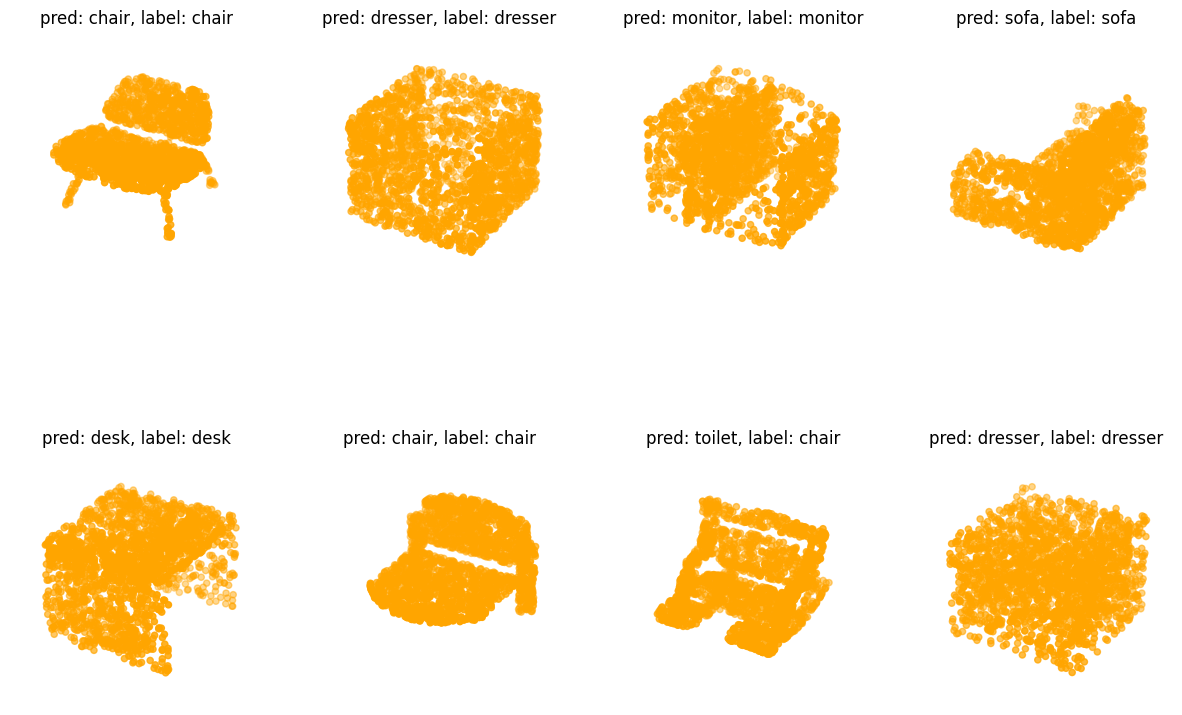

In [29]:
data = test_dataset.take(1)

points, labels = list(data)[0]
points = points[:8, ...]
labels = labels[:8, ...]

# run test data through model
preds = pointnet_model.predict(points)
preds = tf.math.argmax(preds, -1)

points = points.numpy()

# plot points with predicted class and label
fig = plt.figure(figsize=(15, 10))
for i in range(8):
    ax = fig.add_subplot(2, 4, i + 1, projection="3d")
    ax.scatter(points[i, :, 0], points[i, :, 1], points[i, :, 2], c='#FFA500')
    ax.set_title(
        "pred: {:}, label: {:}".format(
            CLASS_MAP[preds[i].numpy()], CLASS_MAP[labels.numpy()[i]]
        )
    )
    ax.set_axis_off()
plt.show()

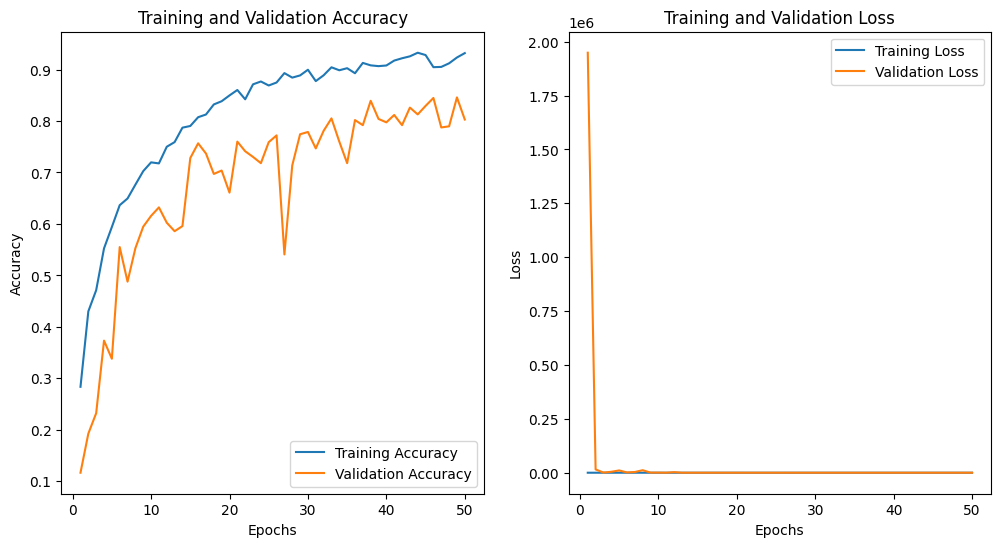

In [31]:
# Plot training and validation accuracy
epochs_range = range(1, EPOCHS+1)  # Assuming 50 epochs
plt.figure(figsize=(12, 6))

# Plot training accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_accuracy, label='Training Accuracy')
plt.plot(epochs_range, val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()